In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
import scipy.stats

Load aggregated behavioral data

In [10]:
beh = np.load('data/aggregated_behavioral_data.npy', allow_pickle=True)
beh_block = np.load('data/aggregated_behavioral_data_block.npy', allow_pickle=True)
glm = np.load('/home/kmb/Desktop/Neuroscience/Projects/FINC_learning_brain/data/derivatives/glm_results_all.npy', allow_pickle=True)
modularity = pd.read_csv('/home/kmb/Desktop/Neuroscience/Projects/FINC_learning_brain/data/derivatives/static_modularity/Q_normalized_power_tidy.csv')

with open('data/aggregated_behavioral_data.json', 'r') as f:
    meta = json.load(f)

# Display hint
for dim in ['dim2', 'dim3', 'dim4', 'dim5']:
    print(dim, ': ', meta[dim])

dim2 :  ['ses-1', 'ses-2', 'ses-3', 'ses-4']
dim3 :  ['acc', 'prt', 'dpr', 'hit_rate', 'fal_rate']
dim4 :  ['1-back', '2-back']
dim5 :  ['vis', 'aud']


# Exclusion criteria

Assumptions:
- Behavioral measure of penalized reaction time (pRT) is considered when exlusion criteria are calculated. 
- Subjects are excluded based on their behavioral performance during the first session. 
- Subjects are excluded based on their performance during both easier 1-back and more demanding 2-back task. 
- Subjects score is calculated as a mean over both visual and auditory modalities.

We aimed to exlude subjects which either did not understand the task or did not deal with the task at all. For each behavioral score, group mean and standard deviation were calculated. We considered subject to be an outlier if his score $x_i$ did not lie within range $(\bar{x}-3\sigma_{x}, \bar{x}+3\sigma_{x})$.

In [5]:
def plot_outliers(scores, thr_lo, thr_hi, measure) -> None:
    '''Distribution of behavioral scores with outliers marked.
    
    Args:
        scores (array_like): Behavioral scores vector for all subjects.
        thr_lo, thr_hi (float): Lower and upper threshold for outlier detection.
        measure (str): Name of the behavioral measures.
    '''

    color = 'steelblue'
    color_outlier = 'crimson'
    
    outliers = (scores < thr_lo) | (scores > thr_hi)

    fig, ax = plt.subplots(figsize=(10, 3), facecolor='w')

    dp = sns.distplot(
        scores, 
        hist=False, 
        kde_kws={},
        rug=True,
        rug_kws={'color': color, 'height': .25 },
        color=color,
        fit_kws={'linestyle': '--'},
        ax=ax)

    ylim = dp.get_ylim()
    x, y = dp.get_lines()[0].get_data()
    x, y = x[(x > thr_lo) & (x < thr_hi)], y[(x > thr_lo) & (x < thr_hi)]
    ax.fill_between(x, y, color='navy', alpha=.2)
    ax.set_ylim(ylim)
    ax.set_yticklabels([])

    if np.any(outliers):    
        ax.axvline(
            x=scores[outliers], 
            ymin=0, 
            ymax=0.25, 
            linewidth=2,
            color=color_outlier)

    ax.set_xlim(left=0)
    ax.set_xlabel(measure)
    ax.set_ylabel('Probability')
    ax.tick_params(direction='in')

####################### pRT (1-back) #######################
Bounds: (636.03, 1796.2)
Number of outliers: 0
####################### pRT (2-back) #######################
Bounds: (1004.4, 2009.4)
Number of outliers: 0


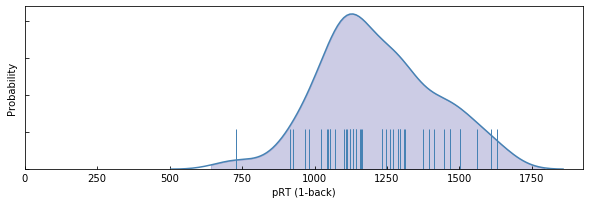

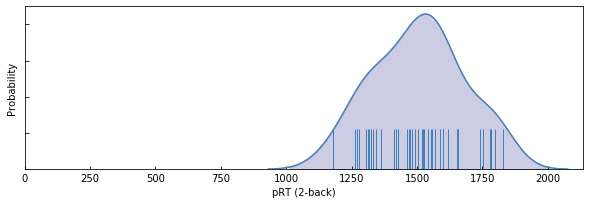

In [39]:
n_std = 3 # Number of +/- stds for outlier detection
ses = meta['dim2'].index('ses-1')
m = meta['dim3'].index('prt')

for c, condition in enumerate(['pRT (1-back)', 'pRT (2-back)']):
    
    scores = np.mean(beh[:, ses, m, c, :], axis=-1)
    
    thr_hi = np.mean(scores) + n_std * np.std(scores)
    thr_lo = np.mean(scores) - n_std * np.std(scores)

    outliers = (scores < thr_lo) | (scores > thr_hi)
    
    print(f' {condition} '.center(60, '#'))
    print(f'Bounds: ({thr_lo:.5}, {thr_hi:.5})')
    print(f'Number of outliers: {np.sum(outliers)}')
    
    if np.sum(outliers) > 0:
            print('Outliers:', [sub for idx, sub in enumerate(meta['dim1']) 
                         if idx in np.nonzero(outliers)[0]])
            
    plot_outliers(scores, thr_lo, thr_hi, condition)

Otliers based on values of modularity.

In [27]:
qnorm = np.zeros((len(meta['dim1']), 2))
qnorm[:, 0] = modularity.loc[(modularity['Session'] == 'Naive') & (modularity['Condition'] == '1-back'), 'Q_norm']
qnorm[:, 1] = modularity.loc[(modularity['Session'] == 'Naive') & (modularity['Condition'] == '2-back'), 'Q_norm']

######################## Q (1-back) ########################
Bounds: (1.8807, 4.0342)
Number of outliers: 0
######################## Q (2-back) ########################
Bounds: (1.6195, 3.9711)
Number of outliers: 0


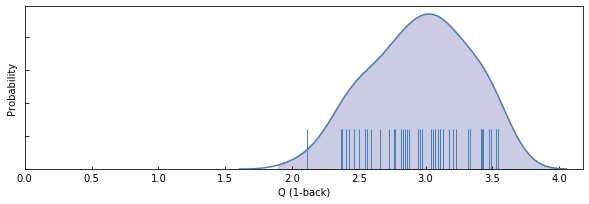

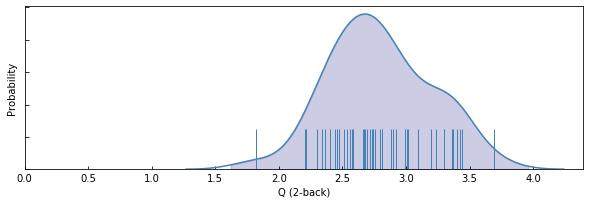

In [34]:
for c, condition in enumerate(['Q (1-back)', 'Q (2-back)']):
    
    scores = qnorm[:, c]
    
    thr_hi = np.mean(scores) + n_std * np.std(scores)
    thr_lo = np.mean(scores) - n_std * np.std(scores)

    outliers = (scores < thr_lo) | (scores > thr_hi)
    
    print(f' {condition} '.center(60, '#'))
    print(f'Bounds: ({thr_lo:.5}, {thr_hi:.5})')
    print(f'Number of outliers: {np.sum(outliers)}')
    
    if np.sum(outliers) > 0:
            print('Outliers:', [sub for idx, sub in enumerate(meta['dim1']) 
                         if idx in np.nonzero(outliers)[0]])
            
    plot_outliers(scores, thr_lo, thr_hi, condition)

# Change in behavioral variability  

In [5]:
bvar = np.stack((
    np.std(np.reshape(np.mean(beh_block[:, :, 0, :, :, :], axis=3), newshape=(46, 4, 20)), axis=2),
    np.std(np.reshape(np.mean(beh_block[:, :, 1, :, :, :], axis=3), newshape=(46, 4, 20)), axis=2),
    np.std(np.reshape(np.mean(beh_block[:, :, 2, :, :, :], axis=3), newshape=(46, 4, 20)), axis=2),
))

var_exp = np.mean(bvar[:, meta['exp'], :], axis=1)
vsd_exp = np.std(bvar[:, meta['exp'], :], axis=1)

var_con = np.mean(bvar[:, meta['con'], :], axis=1)
vsd_con = np.std(bvar[:, meta['con'], :], axis=1)

var_exp.shape

(3, 4)

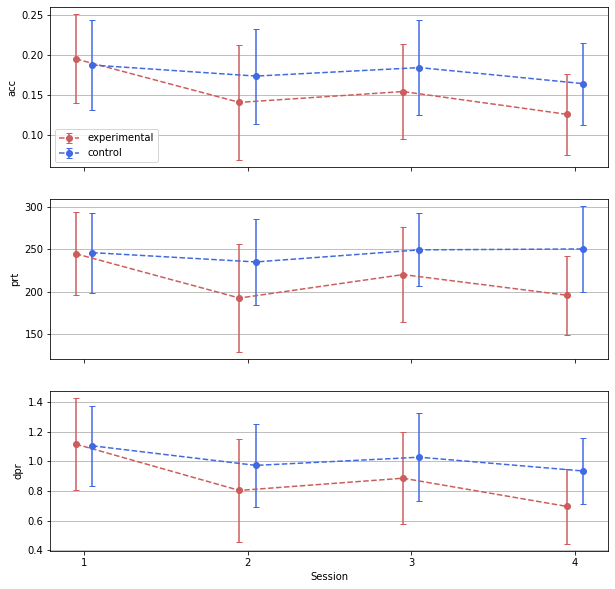

In [6]:
sessions = np.arange(1, 5)
offset = .05

fig, ax = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
kwargs = {
    'capsize': 3,
    'fmt': '--o',
}

for m, measure in enumerate(meta['dim3'][:3]):
    
    ax[m].errorbar(sessions - offset, var_exp[m], vsd_exp[m], 
                   color='indianred', label='experimental', **kwargs)
    ax[m].errorbar(sessions + offset, var_con[m], vsd_con[m], 
                   color='royalblue', label='control', **kwargs)
    ax[m].set_xticks(sessions)
    ax[m].set_ylabel(measure)
    ax[m].yaxis.grid()

ax[0].legend()
ax[-1].set_xlabel('Session')


plt.show()

Save results in tidy format.

In [7]:
n_subjects, n_sessions, n_conditions = 46, 4, 2

subjects, sessions, conditions = [], [], []
vec_acc, vec_prt, vec_dpr = [], [], []

for sub in range(n_subjects):
    for ses in range(n_sessions):
        for con in range(n_conditions):
            
            subjects.append(meta['dim1'][sub])
            sessions.append(meta['dim2'][ses])
            conditions.append(meta['dim4'][con])
            
            vec_acc.append(np.mean(beh, axis=4)[sub, ses, 0, con])
            vec_prt.append(np.mean(beh, axis=4)[sub, ses, 1, con])
            vec_dpr.append(np.mean(beh, axis=4)[sub, ses, 2, con])

df = pd.DataFrame(list(zip(
    subjects, sessions, conditions, 
    vec_acc, vec_prt, vec_dpr)),
            columns=['subjects', 'sessions', 'conditions', 'acc', 'prt', 'dpr'])

df.to_csv('data/beh_tidy.csv')

df.head()

,subjects,sessions,conditions,acc,prt,dpr
0,sub-01,ses-1,1-back,0.866667,1134.228333,3.437119
1,sub-01,ses-1,2-back,0.783333,1520.928797,2.514055
2,sub-01,ses-2,1-back,0.866667,1141.753226,3.429125
3,sub-01,ses-2,2-back,0.866667,1382.946930,3.117902
4,sub-01,ses-3,1-back,0.800000,1329.741820,2.758558


In [8]:
n_subjects, n_sessions, n_conditions = 46, 4, 2

subjects, conditions = [], []
vec_acc, vec_prt, vec_dpr = [], [], []

for sub in range(n_subjects):
    for ses in range(n_sessions):
        
        subjects.append(meta['dim1'][sub])
        sessions.append(meta['dim2'][ses])
        
        vec_acc.append(bvar[0, sub, ses])
        vec_prt.append(bvar[1, sub, ses])
        vec_dpr.append(bvar[2, sub, ses])
            
df = pd.DataFrame(list(zip(
    subjects, sessions, 
    vec_acc, vec_prt, vec_dpr)),
            columns=['subjects', 'sessions', 'std_acc', 'std_prt', 'std_dpr'])

df.to_csv('data/beh_block_variability_tidy.csv')

df.head()

,subjects,sessions,std_acc,std_prt,std_dpr
0,sub-01,ses-1,0.144097,247.900562,0.882973
1,sub-01,ses-1,0.100000,210.087555,0.534458
2,sub-01,ses-2,0.138444,183.441256,0.799822
3,sub-01,ses-2,0.116667,155.025664,0.841678
4,sub-02,ses-3,0.199130,238.724157,1.143088


# Subject strategy

In [9]:
for dim in ['dim3', 'dim4', 'dim5', 'dim6']: print(meta[dim])

['acc', 'prt', 'dpr', 'hit_rate', 'fal_rate']
['1-back', '2-back']
['vis', 'aud']
['block-01', 'block-02', 'block-03', 'block-04', 'block-05', 'block-06', 'block-07', 'block-08', 'block-09', 'block-10']


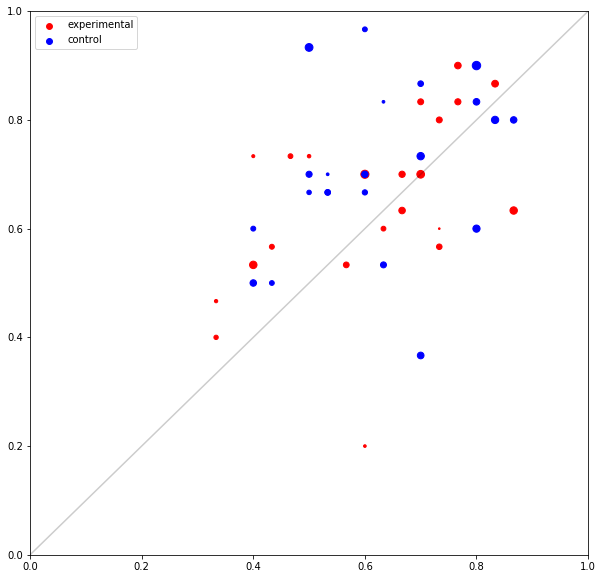

In [10]:
glm_norm = glm + np.abs(np.min(glm, axis=0)) 

m = 0 # accuracy
ses = 0
net = 4 # 4-dmn, 5-fpn   
m_min = 0
m_max = 1


fig, ax = plt.subplots(ncols=1, figsize=(10, 10))


ax.scatter(
    beh[meta['exp'], ses, m, 1, 0], 
    beh[meta['exp'], ses, m, 1, 1], 
    s=glm_norm[meta['exp'], ses, net] * 15,
    color='red', 
    label='experimental'
) 
ax.scatter(
    beh[meta['con'], ses, m, 1, 0], 
    beh[meta['con'], ses, m, 1, 1],
    s=glm_norm[meta['con'], ses, net] * 15,
    color='blue', 
    label='control'
) 
ax.plot([m_min, m_max], [m_min, m_max], 'k-', alpha=.2)
ax.set_xlim([m_min, m_max])
ax.set_ylim([m_min, m_max])
ax.legend()
plt.show()